Midterm Project - Fetal Health Classifier using XGBoost

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score


In [4]:
df = pd.read_csv('fetal_health.csv')

In [5]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
df.isnull().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [7]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [8]:
corr_matrix = df.corr()

<Axes: >

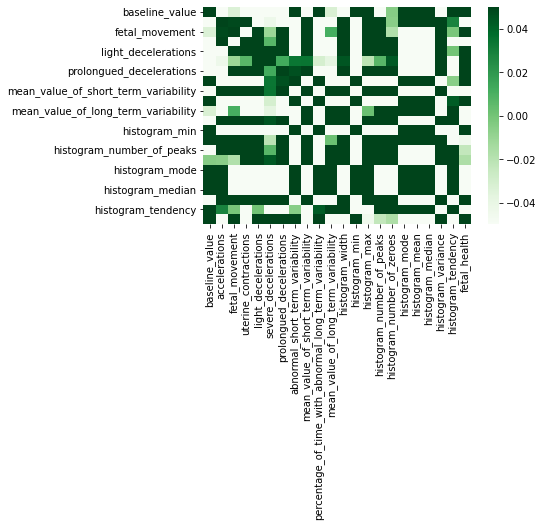

In [9]:
sns.heatmap(corr_matrix, cmap='Greens', vmin =-.05, vmax = .05)

Noting that histogram_number_of_peaks and histogram_number_of_zeroes have correlations with fetal_health that 
are less than 0.05 away from zero so I'll plan to drop those features before training my model.

<Axes: >

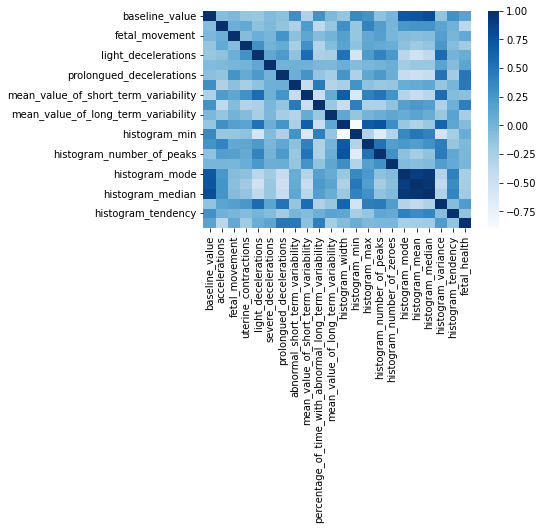

In [17]:
sns.heatmap(corr_matrix, cmap='Blues')

Take a more holistic look, we can see that prolongued_decelerations and abnormal_short_term_variability are some of the features most highly correlated to our target

array([[<Axes: title={'center': 'baseline_value'}>,
        <Axes: title={'center': 'accelerations'}>],
       [<Axes: title={'center': 'fetal_movement'}>,
        <Axes: title={'center': 'uterine_contractions'}>],
       [<Axes: title={'center': 'light_decelerations'}>,
        <Axes: title={'center': 'severe_decelerations'}>],
       [<Axes: title={'center': 'prolongued_decelerations'}>,
        <Axes: title={'center': 'abnormal_short_term_variability'}>],
       [<Axes: title={'center': 'mean_value_of_short_term_variability'}>,
        <Axes: title={'center': 'percentage_of_time_with_abnormal_long_term_variability'}>],
       [<Axes: title={'center': 'mean_value_of_long_term_variability'}>,
        <Axes: title={'center': 'histogram_width'}>],
       [<Axes: title={'center': 'histogram_min'}>,
        <Axes: title={'center': 'histogram_max'}>],
       [<Axes: title={'center': 'histogram_number_of_peaks'}>,
        <Axes: title={'center': 'histogram_number_of_zeroes'}>],
       [<Axe

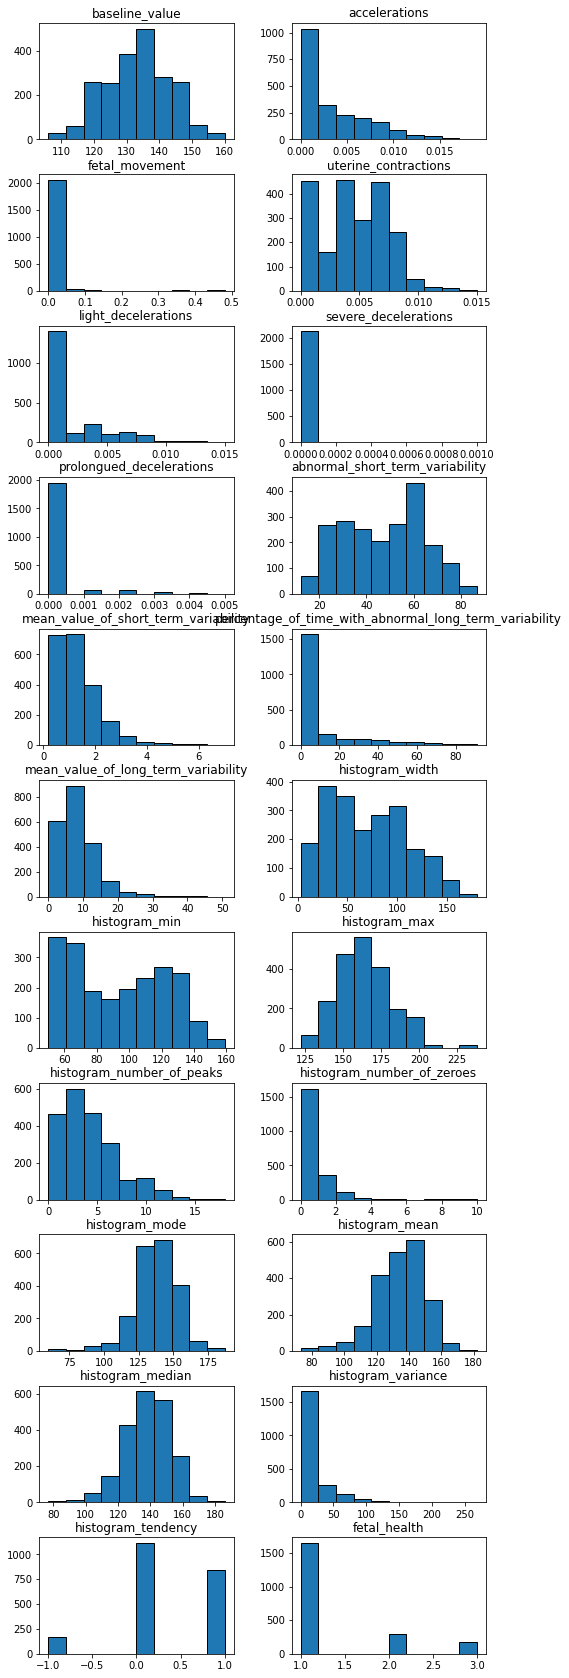

In [11]:
# Checking out the histograms
fig, axis = plt.subplots(11, 2, figsize=(8,30))
df.hist(ax=axis, grid=False, edgecolor='black')

In [12]:
# let's simplify this into a binary classification problem and remap healthy to 0 and unhealthy codes to 1
fetal_health_dict = {
    1: 0,
    2: 1,
    3: 1,
}
df.fetal_health = df.fetal_health.map(fetal_health_dict)

In [13]:
# and drop the features w/ particularly low corr
df.drop(['histogram_number_of_peaks','histogram_number_of_zeroes'], axis = 1, inplace = True)

In [20]:
# splitting the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fetal_health.values
y_val = df_val.fetal_health.values
y_test = df_test.fetal_health.values

del df_train['fetal_health']
del df_val['fetal_health']
del df_test['fetal_health']

In [21]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [22]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [23]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=50)

In [24]:
y_pred = model.predict(dval)

In [25]:
roc_auc_score(y_val, y_pred)

0.9852751139223288

Looking amazing so far! Let's watch the model learn to see how many boost rounds are really necessary

In [26]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [27]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric':'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=300,verbose_eval=5,evals=watchlist)

In [28]:
scores = output.stdout

In [29]:
print(scores[:])

[0]	train-auc:0.96780	val-auc:0.93192
[5]	train-auc:0.99794	val-auc:0.97852
[10]	train-auc:0.99920	val-auc:0.98133
[15]	train-auc:0.99978	val-auc:0.98177
[20]	train-auc:1.00000	val-auc:0.98354
[25]	train-auc:1.00000	val-auc:0.98429
[30]	train-auc:1.00000	val-auc:0.98402
[35]	train-auc:1.00000	val-auc:0.98429
[40]	train-auc:1.00000	val-auc:0.98534
[45]	train-auc:1.00000	val-auc:0.98449
[50]	train-auc:1.00000	val-auc:0.98514
[55]	train-auc:1.00000	val-auc:0.98528
[60]	train-auc:1.00000	val-auc:0.98545
[65]	train-auc:1.00000	val-auc:0.98545
[70]	train-auc:1.00000	val-auc:0.98572
[75]	train-auc:1.00000	val-auc:0.98545
[80]	train-auc:1.00000	val-auc:0.98524
[85]	train-auc:1.00000	val-auc:0.98504
[90]	train-auc:1.00000	val-auc:0.98528
[95]	train-auc:1.00000	val-auc:0.98511
[100]	train-auc:1.00000	val-auc:0.98497
[105]	train-auc:1.00000	val-auc:0.98497
[110]	train-auc:1.00000	val-auc:0.98470
[115]	train-auc:1.00000	val-auc:0.98480
[120]	train-auc:1.00000	val-auc:0.98446
[125]	train-auc:1.0000

Our model clearly doesn't need many rounds of boosting. Let's look at log-loss and see if we can settle on a boosting value

In [30]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_log_loss', 'val_log_loss']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [31]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    #'eval_metric':'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=300,verbose_eval=5,evals=watchlist)

In [32]:
df_score = parse_xgb_output(output)

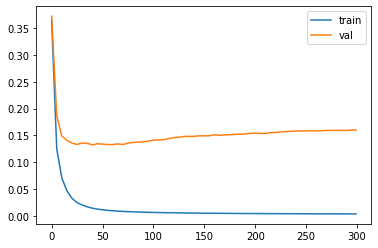

In [33]:
plt.plot(df_score.num_iter, df_score.train_log_loss, label='train')
plt.plot(df_score.num_iter, df_score.val_log_loss, label='val')
plt.legend()

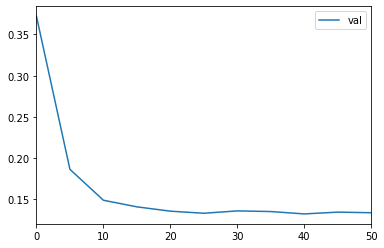

In [34]:
plt.plot(df_score.num_iter, df_score.val_log_loss, label='val')
plt.xlim((0,50))
plt.legend()

Let's use 40 rounds of boosting moving forward!

In [35]:
num_boost_round=40

Now let's try tuning eta

In [36]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [37]:
scores = {}

In [38]:
%%capture output
xgb_params = {
'eta': .01, 
'max_depth': 6,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,verbose_eval=5,evals=watchlist)

In [39]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

In [40]:
%%capture output
xgb_params = {
'eta': .1, 
'max_depth': 6,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,verbose_eval=5,evals=watchlist)

In [41]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

In [42]:
%%capture output
xgb_params = {
'eta': .3, 
'max_depth': 6,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,verbose_eval=5,evals=watchlist)

In [43]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

In [44]:
%%capture output
xgb_params = {
'eta': .5, 
'max_depth': 6,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,verbose_eval=5,evals=watchlist)

In [45]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

[]

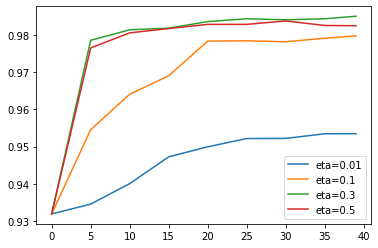

In [46]:
for eta, df_eta_scores in scores.items():
    plt.plot(df_eta_scores.num_iter, df_eta_scores.val_auc, label = eta)
    
plt.legend()
plt.plot()

eta=0.3 looks to be optimal

Now let's test min_child_weight

In [47]:
scores = {}

In [48]:
%%capture output
xgb_params = {
'eta': .3, 
'max_depth': 6,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,verbose_eval=5,evals=watchlist)

In [49]:
key = f'min_child_weight={xgb_params["min_child_weight"]}'
scores[key] = parse_xgb_output(output)

In [50]:
%%capture output
xgb_params = {
'eta': .3, 
'max_depth': 6,
'min_child_weight': 10,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,verbose_eval=5,evals=watchlist)

In [51]:
key = f'min_child_weight={xgb_params["min_child_weight"]}'
scores[key] = parse_xgb_output(output)

[]

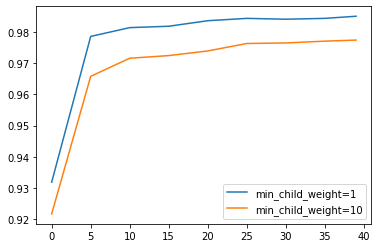

In [52]:
for min_child_weight, df_min_child_weight_scores in scores.items():
    plt.plot(df_min_child_weight_scores.num_iter, df_min_child_weight_scores.val_auc, label = min_child_weight)
    
plt.legend()
plt.plot()

We'll stick with a min_child_weight of 1. The model is looking great!

Let's train the final model with min_child_weight = 1, eta = .3, and num_boost_round = 40

In [53]:
xgb_params = {
'eta': .3, 
'max_depth': 6,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthread': 8,
'eval_metric':'auc',

'seed': 1,
'verbosity': 1,
}

model_final = xgb.train(xgb_params, dtrain, num_boost_round=40)